The goal of this project is to classify 10 different types of flowers. The types are following:
1. aster 
2. daffodil
3. dahlia
4. daisy
5. dandelion
6. iris
7. orchid
8. rose
9. sunflower
10. tulip

## Setting up

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
bs = 8 # batch size

In [2]:
!pip install -Uqq fastai fastbook nbdev

In [3]:
from fastai import *
from fastbook import *
from fastai.vision.all import *

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/My Drive/MasterCourse/Flowers Recognizer

/content/drive/My Drive/MasterCourse/Flowers Recognizer


# Getting the Data

We will use the DuckDuckGo image search

In [6]:
doc(search_images_ddg)

In [7]:
flower_labels = [
    "aster",
    "daffodil",
    "dahlia",
    "daisy",
    "dandelion",
    "iris",
    "orchid",
    "rose",
    "sunflower",
    "tulip"
]
len(flower_labels)

10

In [8]:
images = search_images_ddg(flower_labels[0])
f"No of Images => {len(images)} -- One Image URL => {images[0]}"

'No of Images => 200 -- One Image URL => https://cdn.shopify.com/s/files/1/1095/8052/products/Aster_Tower_Chamois.jpg?v=1575579237'

In [9]:
doc(download_url)

In [10]:
dest = "aster.jpg"
download_url(images[0], dest, show_progress=False)

Path('aster.jpg')

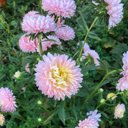

In [11]:
image = Image.open(dest)
image.to_thumb(128, 128)

In [12]:
data_path = "data"
if not os.path.exists(data_path): 
  os.mkdir(data_path)

for flower_type in flower_labels:

  dest = f"{data_path}/{flower_type}"
  if not os.path.exists(dest): 
    os.mkdir(dest)

  try:
    flower_image_urls = search_images_ddg(flower_type)
    download_images(dest, urls = flower_image_urls)
    
  except:
    continue

In [13]:
image_counts = get_image_files(data_path)
image_counts

(#1847) [Path('data/aster/8a2aa221-a4b1-46a0-a245-e688ac134f8c.jpg'),Path('data/aster/ccef5a78-4c5e-43eb-a69c-33c0b3aa3512.jpg'),Path('data/aster/4e297418-52ad-4ddf-8954-eb47e5b390d3.jpg'),Path('data/aster/6791377b-6600-4b86-89dd-bd52d7a26339.jpg'),Path('data/aster/2aa54cb3-f193-48a8-b78e-df4bf3535d34.jpg'),Path('data/aster/14252bdb-6e88-4a7f-a38c-3d17e9d75ae9.jpg'),Path('data/aster/3163d3b8-caf8-4a82-ac01-d4ed5345b0cf.jpg'),Path('data/aster/7e6c8400-606a-426b-9d8b-91452168b4c6.jpg'),Path('data/aster/922a3675-18d3-416a-8f00-943586ecccc0.JPG'),Path('data/aster/efda90ad-e062-4bbd-bdfd-ab2b3ff89a90.jpg')...]

In [14]:
failed = verify_images(image_counts)
failed

(#113) [Path('data/aster/2aa54cb3-f193-48a8-b78e-df4bf3535d34.jpg'),Path('data/aster/e4d744ac-27d2-43ab-b83b-b2cadd843e85.jpg'),Path('data/aster/330f4d5c-92cb-4615-97d7-36608bc33f09.jpg'),Path('data/aster/fd134e6a-0816-4cbc-8b44-d36554718d63.jpg'),Path('data/aster/1839b837-338c-4941-8725-a17209afdf4d.jpg'),Path('data/aster/935f423b-df04-4fce-bdb7-3c1fce2ba4a7.jpg'),Path('data/aster/cefd3f34-ff4e-4c83-b7ad-73d93b740104.jpg'),Path('data/daffodil/45f05327-772c-4508-af54-2e65be58abe3.jpg'),Path('data/daffodil/3640503f-b6c3-4452-9664-f6af4f72f72e.jpg'),Path('data/daffodil/ef0a3879-5681-4a02-81c9-7bdff53a9f17.jpg')...]

In [15]:
failed.map(Path.unlink)

(#113) [None,None,None,None,None,None,None,None,None,None...]

## Data to Data loaders

In [16]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files,                        # get_image_files returns a list of all images in that path recursively by default
    splitter=RandomSplitter(valid_pct=0.1, seed=42),  # getting 90-10 train-validation split
    get_y=parent_label,                               # taking the folder name as labels
    item_tfms=Resize(128))                            # resizing to get the image of same shape

In [17]:
dls = dblock.dataloaders(data_path,bs=bs)             # setting up batch size for efficient GPU use

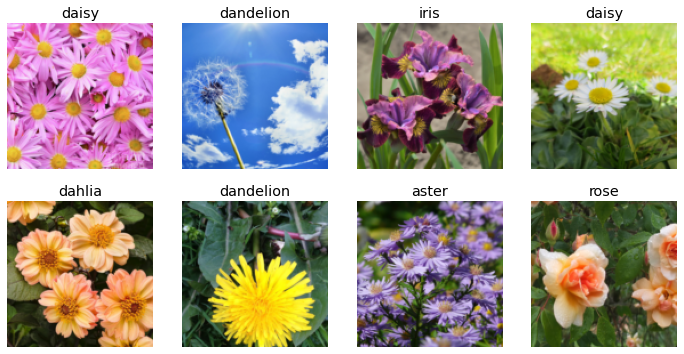

In [18]:
dls.train.show_batch(max_n=8, nrows=2)

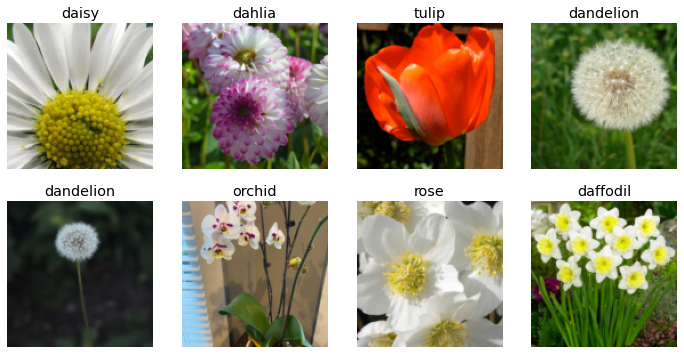

In [19]:
dls.valid.show_batch(max_n=8, nrows=2)

## Data Augmentation

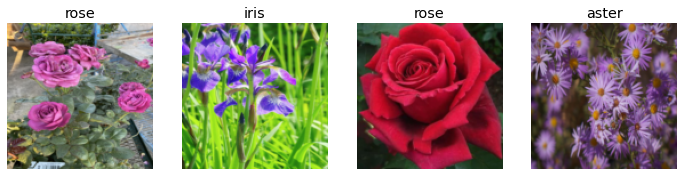

In [20]:
dblock = dblock.new(item_tfms = Resize(128, ResizeMethod.Squish)) #Squishing the whole images to (128x128) format
dls = dblock.dataloaders(data_path)
dls.train.show_batch(max_n=4, nrows=1)

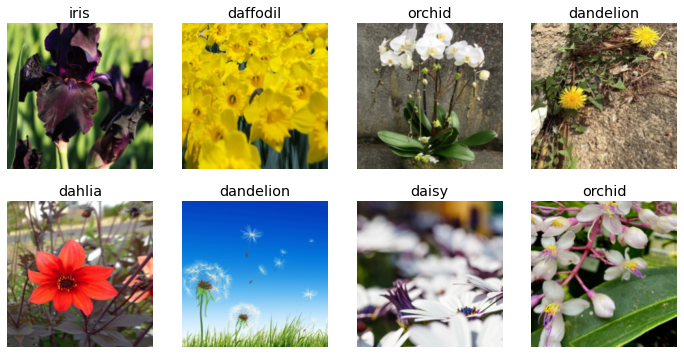

In [21]:
dblock = dblock.new(item_tfms = RandomResizedCrop(224, min_scale = 0.5), batch_tfms = aug_transforms())
dls = dblock.dataloaders(data_path)
dls.train.show_batch(max_n=8, nrows=2)

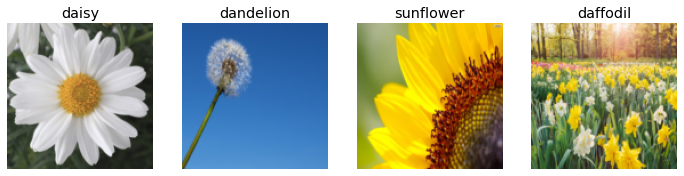

In [22]:
dblock = dblock.new(item_tfms = Resize(128, ResizeMethod.Squish)) #Squishing the whole images to (128x128) format
dls = dblock.dataloaders(data_path)
dls.valid.show_batch(max_n=4, nrows=1)

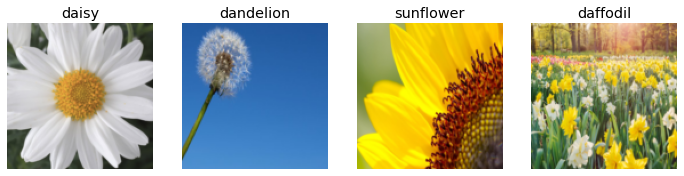

In [23]:
dblock = dblock.new(item_tfms = RandomResizedCrop(128, min_scale = 0.3)) #Randomly customizing images
dls = dblock.dataloaders(data_path)
dls.valid.show_batch(max_n=4, nrows=1)

In [25]:
torch.save(dls, "flower_dataloader_v0.pkl")